In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.0.12 installed at /global/u2/y/ybh0822/packages/CAMB-1.0.12/camb


#### Define a function to compute $P_{gg}$

In [2]:
# Compute gg power spectrum

def compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, mnu=0.06, 
                tau=0.06, w_DE=-0.95, wa=0, dmodel = 'ppf', NL_Pk = True):
    """
    Compute gg power spectrum given cosmology (mostly from https://camb.readthedocs.io/en/latest/CAMBdemo.html)
    
    Parameters
    ------------
    H0 – Hubble parameter today in km/s/Mpc. Can leave unset and instead set thetastar or cosmomc_theta.
    cosmomc_theta – The approximate CosmoMC theta parameter. Leave unset to use H0 or thetastar.
    fix_H0 - Setting H0 and unsetting cosmomc_theta. default is True.
    ombh2 – physical density in baryons.
    omch2 – physical density in cold dark matter.
    ns – scalar spectral index.
    As - comoving curvature power at k=pivot_scalar.
    mnu – sum of neutrino masses (in eV).
    tau – optical depth.
    w_DE - w(0).
    wa - dw/da(0).
    dmodel - 'fluid' or 'ppf'
    NL_Pk - Using nonlinear power spectrum from Halofit. Default is True.
    """

    # Set up a set of parameters for CAMB
    pars = camb.CAMBparams()
    
    # Setting H0 or cosmomc_theta
    if fix_H0==True:
        pars.set_cosmology(H0=H0, cosmomc_theta=None, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau, nnu=3.046, standard_neutrino_neff=3.046, num_massive_neutrinos = 1, neutrino_hierarchy='degenerate')
    else:
        pars.set_cosmology(H0=None, cosmomc_theta=cosmomc_theta, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau, nnu=3.046, standard_neutrino_neff=3.046, num_massive_neutrinos = 1, neutrino_hierarchy='degenerate')
    
    # Set params for the primordial power spectrum
    pars.InitPower.set_params(ns=ns, r=0, As=As)
    pars.set_for_lmax(3000, lens_potential_accuracy=3, max_eta_k=30*3000)
    
    # Set dark energy params
    pars.set_dark_energy(w=w_DE,wa=wa,dark_energy_model=dmodel) 
    
    # Calculate results for these parameters
    results = camb.get_results(pars)

    # Omega_m
    om_tot = ( ombh2+omch2+mnu/94.07*(3.046/3.0)**0.75 )/((pars.H0/100)**2)

    nz = 3002 #number of steps to use for the radial/redshift integration
    kmax=10  #kmax to use

    # Want integration over \chi (comoving radial distance), from 0 to chi_*.
    results= camb.get_background(pars)
    chistar = results.conformal_time(0)- results.tau_maxvis
    chis = np.linspace(0,chistar,nz)
    zs=results.redshift_at_comoving_radial_distance(chis)

    # Calculate array of delta_chi, and drop first and last points where things go singular
    dchis = (chis[2:]-chis[:-2])/2
    dzs = (zs[2:]-zs[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]

    # Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
    PK_gg = camb.get_matter_power_interpolator(pars, nonlinear=NL_Pk, 
        hubble_units=False, k_hunit=False, kmax=kmax, var1=model.Transfer_nonu, var2=model.Transfer_nonu,
        zmax=zs[-1])

    # Re-set w to its fiducial value
    pars.set_dark_energy() 
    
    return PK_gg

#### Compute the derivative of the power spectrum $P(z, k)$ with respect to $w_{0}$ (set $\Delta w = 0.05$)

In [3]:
# Fixing H0, nonlinear PK
# w_DE=-0.95
PK_gg_fixH0 = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95, wa=0, dmodel = 'ppf', NL_Pk = True)
# w_DE=-0.95+0.05/2
PK_gg_dwp05_fixH0 = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95+0.05/2, wa=0, dmodel = 'ppf', NL_Pk = True)
# w_DE=-0.95-0.05/2
PK_gg_dwm05_fixH0 = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95-0.05/2, wa=0, dmodel = 'ppf', NL_Pk = True)

In [4]:
# Fixing cosmomc_theta, nonlinear PK
# w_DE=-0.95
PK_gg_fixtheta = compute_Pgg(H0=None, cosmomc_theta=1.04087e-2, fix_H0=False, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95, wa=0, dmodel = 'ppf', NL_Pk = True)
# w_DE=-0.95+0.05/2
PK_gg_dwp05_fixtheta = compute_Pgg(H0=None, cosmomc_theta=1.04087e-2, fix_H0=False, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95+0.05/2, wa=0, dmodel = 'ppf', NL_Pk = True)
# w_DE=-0.95-0.05/2
PK_gg_dwm05_fixtheta = compute_Pgg(H0=None, cosmomc_theta=1.04087e-2, fix_H0=False, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95-0.05/2, wa=0, dmodel = 'ppf', NL_Pk = True)

In [5]:
# Fixing H0, linear PK
# w_DE=-0.95
PK_gg_fixH0_linear = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95, wa=0, dmodel = 'ppf', NL_Pk = False)
# w_DE=-0.95+0.05/2
PK_gg_dwp05_fixH0_linear = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95+0.05/2, wa=0, dmodel = 'ppf', NL_Pk = False)
# w_DE=-0.95-0.05/2
PK_gg_dwm05_fixH0_linear = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95-0.05/2, wa=0, dmodel = 'ppf', NL_Pk = False)

In [8]:
# Fixing cosmomc_theta, linear PK
# w_DE=-0.95
PK_gg_fixtheta_linear = compute_Pgg(H0=None, cosmomc_theta=1.04087e-2, fix_H0=False, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95, wa=0, dmodel = 'ppf', NL_Pk = False)
# w_DE=-0.95+0.05/2
PK_gg_dwp05_fixtheta_linear = compute_Pgg(H0=None, cosmomc_theta=1.04087e-2, fix_H0=False, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95+0.05/2, wa=0, dmodel = 'ppf', NL_Pk = False)
# w_DE=-0.95-0.05/2
PK_gg_dwm05_fixtheta_linear = compute_Pgg(H0=None, cosmomc_theta=1.04087e-2, fix_H0=False, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95-0.05/2, wa=0, dmodel = 'ppf', NL_Pk = False)

In [6]:
# Fixing H0, linear PK, fluid DE model
# w_DE=-0.95
PK_gg_fixH0_linear_fluid = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95, wa=0, dmodel = 'fluid', NL_Pk = False)
# w_DE=-0.95+0.05/2
PK_gg_dwp05_fixH0_linear_fluid = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95+0.05/2, wa=0, dmodel = 'fluid', NL_Pk = False)
# w_DE=-0.95-0.05/2
PK_gg_dwm05_fixH0_linear_fluid = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                          mnu=0.06, tau=0.06, w_DE=-0.95-0.05/2, wa=0, dmodel = 'fluid', NL_Pk = False)

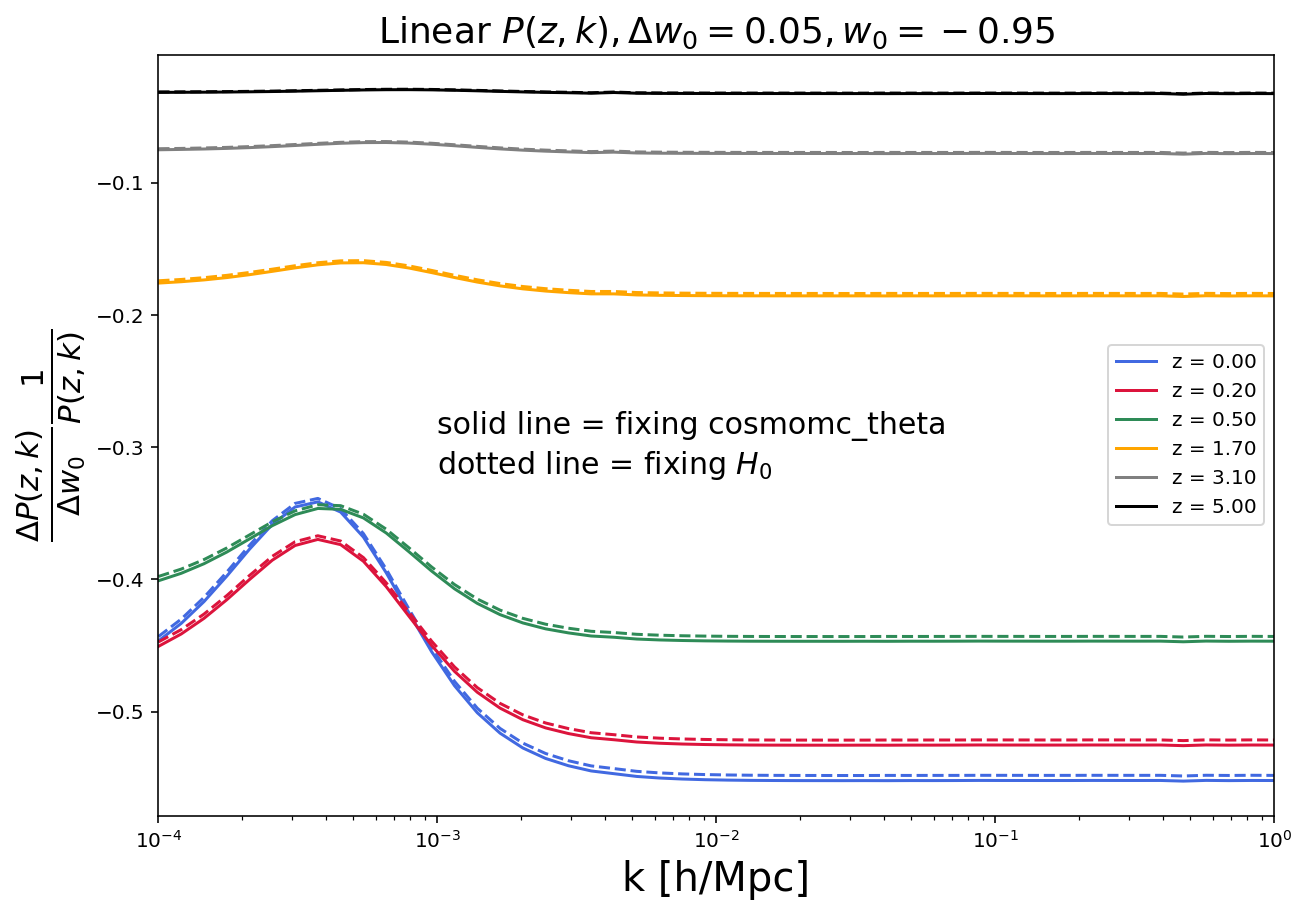

In [18]:
plt.figure(figsize = (10,7))
k = np.logspace(-4,0)

colors = ['royalblue', 'crimson', 'seagreen', 'orange', 'grey', 'black']

dw = 0.05
zpick = [0, .2, .5, 1.7, 3.1, 5]
for i in range(6):
    plt.semilogx(k, (PK_gg_dwp05_fixtheta_linear.P(zpick[i], k, grid=False)-PK_gg_dwm05_fixtheta_linear.P(zpick[i], k, grid=False))/PK_gg_fixtheta_linear.P(zpick[i], k, grid=False)/dw, label = 'z = %.2f' %zpick[i], color = colors[i])
    plt.semilogx(k, (PK_gg_dwp05_fixH0_linear.P(zpick[i], k, grid=False)-PK_gg_dwm05_fixH0_linear.P(zpick[i], k, grid=False))/PK_gg_fixH0_linear.P(zpick[i], k, grid=False)/dw, '--', color = colors[i])

    
plt.xlim(1e-4, 1)
plt.legend()
plt.xlabel('k [h/Mpc]', fontsize = 20)
plt.ylabel('$\\frac{\Delta P(z,k)}{\Delta w_0} \\frac{1}{P(z,k)}$', fontsize = 22)
plt.title('Linear $P(z,k), \Delta w_0 = 0.05, w_0 = -0.95$', fontsize = 18)
plt.text(0.001, -0.29, 'solid line = fixing cosmomc_theta', fontsize = 15)
plt.text(0.001, -0.32, 'dotted line = fixing $H_0$', fontsize = 15)
plt.show()

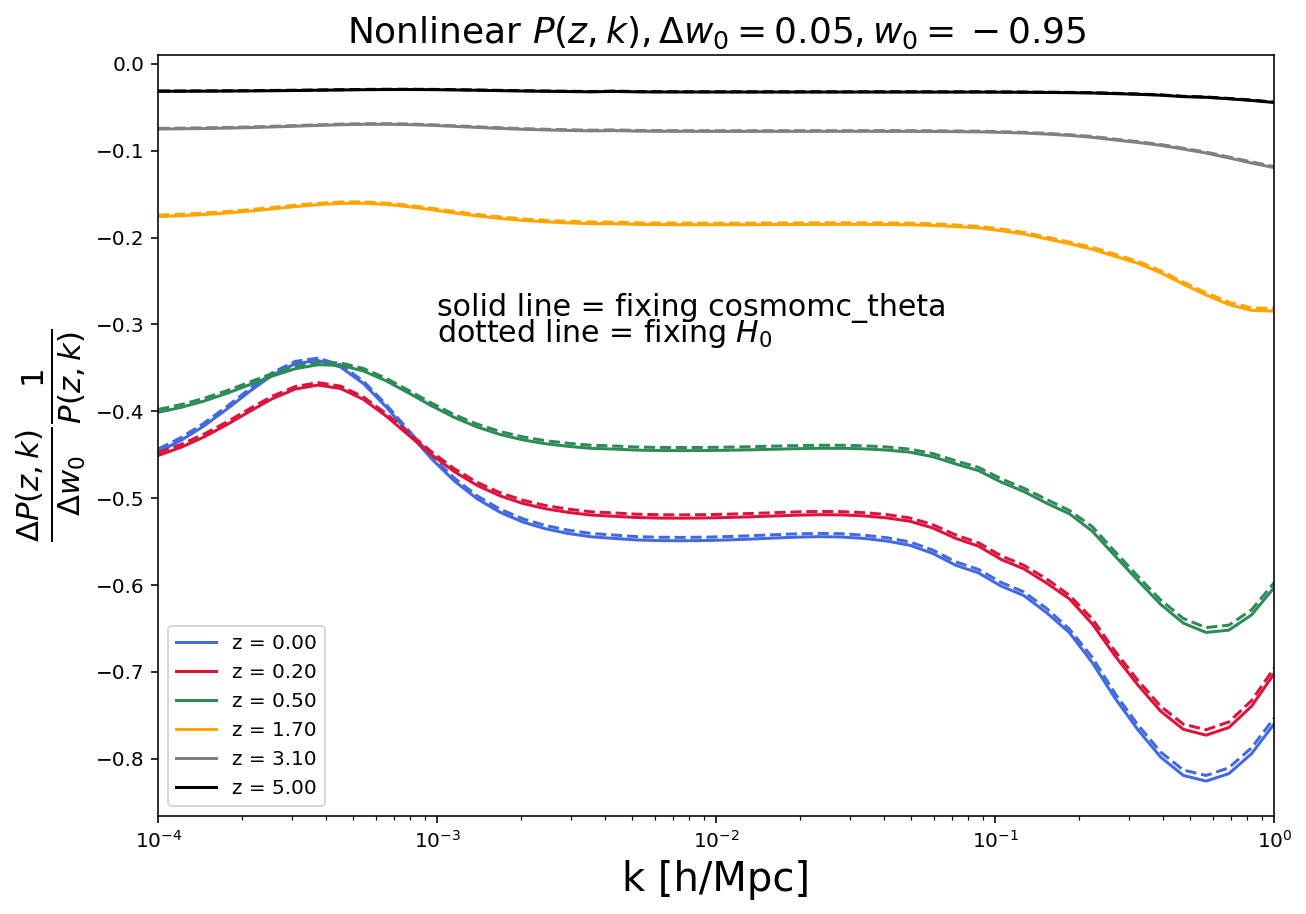

In [19]:
plt.figure(figsize = (10,7))
k = np.logspace(-4,0)

colors = ['royalblue', 'crimson', 'seagreen', 'orange', 'grey', 'black']

dw = 0.05
zpick = [0, .2, .5, 1.7, 3.1, 5]
for i in range(6):
    plt.semilogx(k, (PK_gg_dwp05_fixtheta.P(zpick[i], k, grid=False)-PK_gg_dwm05_fixtheta.P(zpick[i], k, grid=False))/PK_gg_fixtheta.P(zpick[i], k, grid=False)/dw, label = 'z = %.2f' %zpick[i], color = colors[i])
    plt.semilogx(k, (PK_gg_dwp05_fixH0.P(zpick[i], k, grid=False)-PK_gg_dwm05_fixH0.P(zpick[i], k, grid=False))/PK_gg_fixH0.P(zpick[i], k, grid=False)/dw, '--', color = colors[i])

    
plt.xlim(1e-4, 1)
plt.legend()
plt.xlabel('k [h/Mpc]', fontsize = 20)
plt.ylabel('$\\frac{\Delta P(z,k)}{\Delta w_0} \\frac{1}{P(z,k)}$', fontsize = 22)
plt.title('Nonlinear $P(z,k), \Delta w_0 = 0.05, w_0 = -0.95$', fontsize = 18)
plt.text(0.001, -0.29, 'solid line = fixing cosmomc_theta', fontsize = 15)
plt.text(0.001, -0.32, 'dotted line = fixing $H_0$', fontsize = 15)
plt.show()

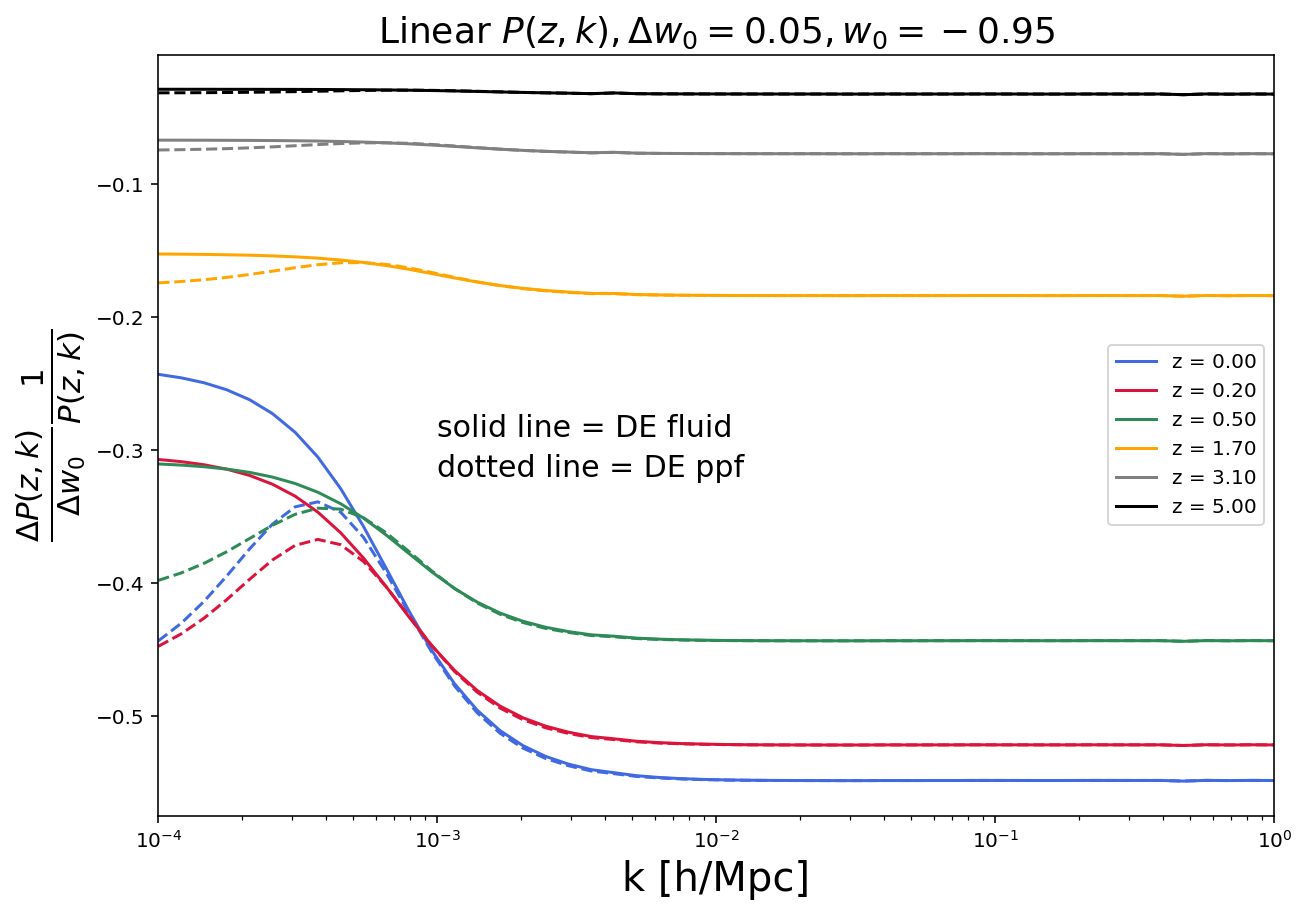

In [7]:
plt.figure(figsize = (10,7))
k = np.logspace(-4,0)

colors = ['royalblue', 'crimson', 'seagreen', 'orange', 'grey', 'black']

dw = 0.05
zpick = [0, .2, .5, 1.7, 3.1, 5]
for i in range(6):
    plt.semilogx(k, (PK_gg_dwp05_fixH0_linear_fluid.P(zpick[i], k, grid=False)-PK_gg_dwm05_fixH0_linear_fluid.P(zpick[i], k, grid=False))/PK_gg_fixH0_linear_fluid.P(zpick[i], k, grid=False)/dw, label = 'z = %.2f' %zpick[i], color = colors[i])
    plt.semilogx(k, (PK_gg_dwp05_fixH0_linear.P(zpick[i], k, grid=False)-PK_gg_dwm05_fixH0_linear.P(zpick[i], k, grid=False))/PK_gg_fixH0_linear.P(zpick[i], k, grid=False)/dw, '--', color = colors[i])

    
plt.xlim(1e-4, 1)
plt.legend()
plt.xlabel('k [h/Mpc]', fontsize = 20)
plt.ylabel('$\\frac{\Delta P(z,k)}{\Delta w_0} \\frac{1}{P(z,k)}$', fontsize = 22)
plt.title('Linear $P(z,k), \Delta w_0 = 0.05, w_0 = -0.95$', fontsize = 18)
plt.text(0.001, -0.29, 'solid line = DE fluid', fontsize = 15)
plt.text(0.001, -0.32, 'dotted line = DE ppf', fontsize = 15)
plt.show()

#### Is $dP_{gg}/dw$ smooth?

In [24]:
dw_array = -0.95+np.linspace(-0.15, 0.15, 10)
Pgg_array = []
for i in range(len(dw_array)):
    Pgg = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                      mnu=0.06, tau=0.06, w_DE=dw_array[i], wa=0, dmodel = 'ppf', NL_Pk = False)
    Pgg_array.append( Pgg.P(1, 0.01, grid=False) )

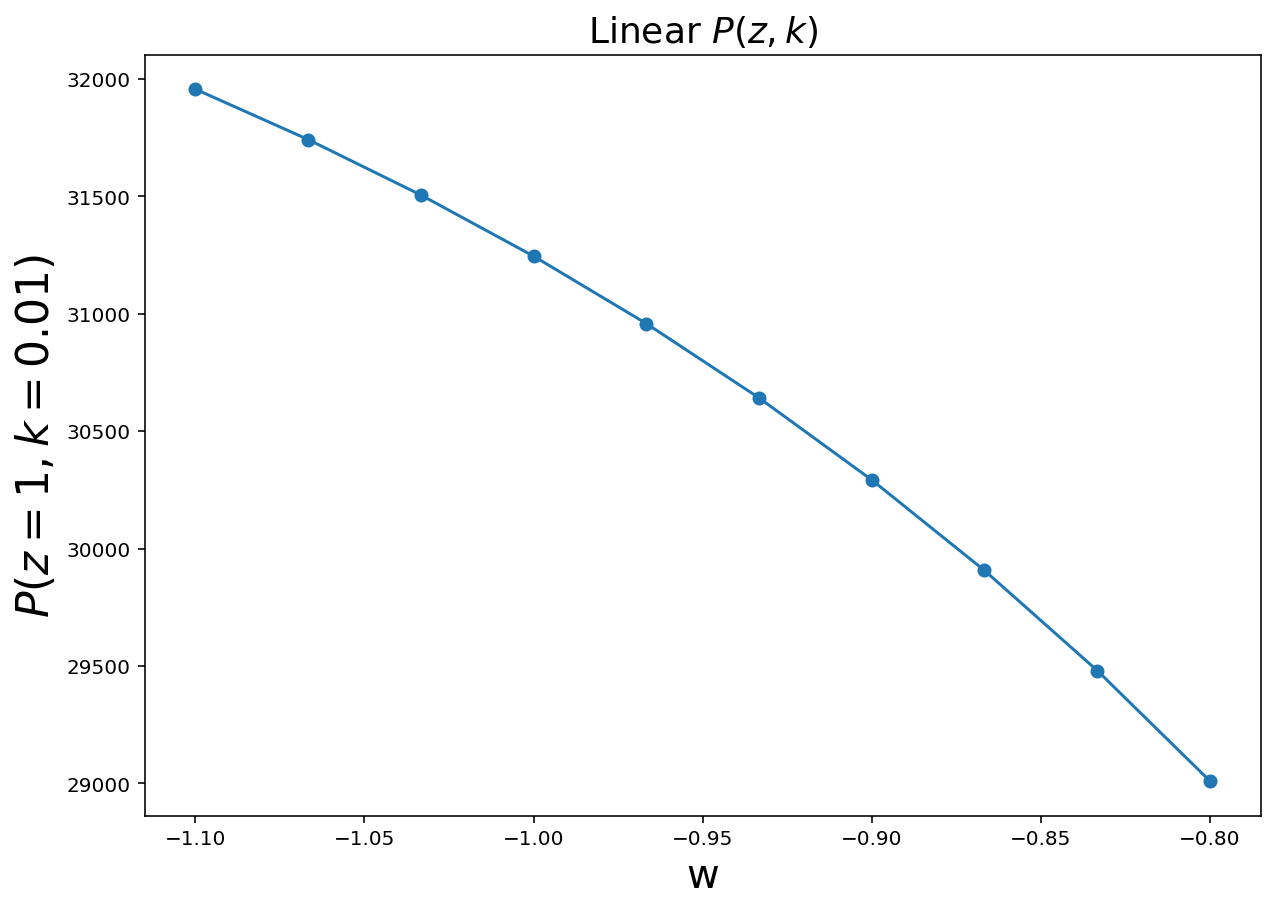

In [26]:
plt.figure(figsize = (10,7))

plt.plot(dw_array, Pgg_array, 'o-')
    
plt.xlabel('w', fontsize = 20)
plt.ylabel('$P(z=1,k=0.01)$', fontsize = 22)
plt.title('Linear $P(z,k)$', fontsize = 18)
plt.show()

In [27]:
dw_array = -0.95+np.linspace(-0.15, 0.15, 10)
Pgg_array = []
for i in range(len(dw_array)):
    Pgg = compute_Pgg(H0=67.0, cosmomc_theta=None, fix_H0=True, ombh2=0.022, omch2=0.1194, ns=0.96, As=2.2e-9, 
                      mnu=0.06, tau=0.06, w_DE=dw_array[i], wa=0, dmodel = 'ppf', NL_Pk = True)
    Pgg_array.append( Pgg.P(1, 0.01, grid=False) )

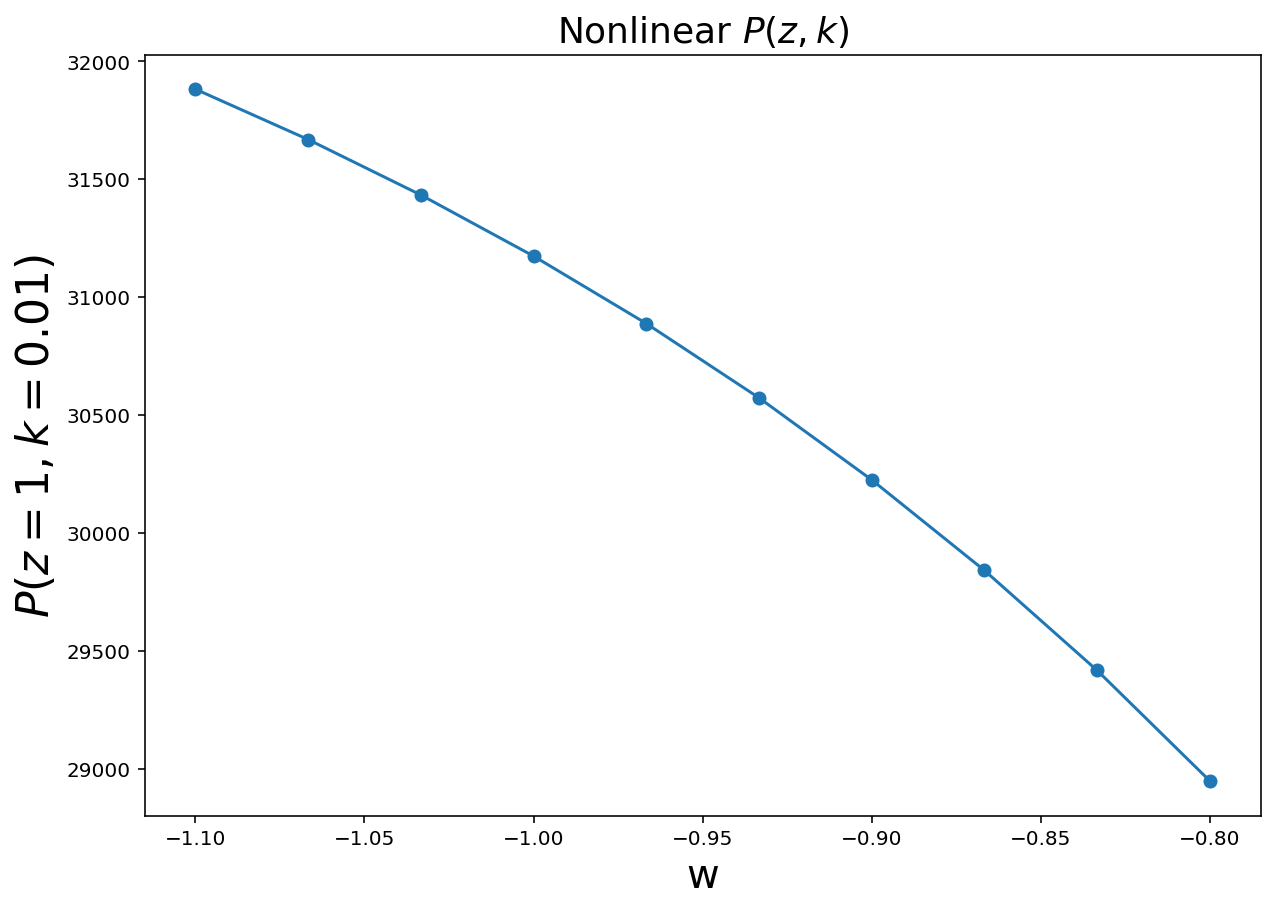

In [29]:
plt.figure(figsize = (10,7))

plt.plot(dw_array, Pgg_array, 'o-')
    
plt.xlabel('w', fontsize = 20)
plt.ylabel('$P(z=1,k=0.01)$', fontsize = 22)
plt.title('Nonlinear $P(z,k)$', fontsize = 18)
plt.show()